In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

# Read data

In [2]:
listings_file_path = 'data/airbnb/listings.csv'
al_file_path = 'data/Alojamento_Local.csv'
df_al = pd.read_csv(al_file_path)
df_listings = pd.read_csv(listings_file_path)
df_listings.head()

/Users/air/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6499,https://www.airbnb.com/rooms/6499,20200128033557,2020-01-28,Belém 1 Bedroom Historical Apartment,"This apartment is all about Location, next to ...",Fully furnished apartment (35m2). Small inside...,"This apartment is all about Location, next to ...",none,"To get to the city center, tram 15 stops in f...",...,t,f,moderate,f,f,1,1,0,0,0.39
1,25659,https://www.airbnb.com/rooms/25659,20200128033557,2020-01-28,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Sunny 1 Bedroom cozy apartment in historic Alf...,"Charming, sunny, cozy apartment in the heart o...",Sunny 1 Bedroom cozy apartment in historic Alf...,none,Alfama is the oldest and most picturesque quar...,...,t,f,moderate,f,f,1,1,0,0,1.61
2,28066,https://www.airbnb.com/rooms/28066,20200128033557,2020-01-29,ear the birds,NaN,traditional farm house in a quiet place where ...,traditional farm house in a quiet place where ...,none,NaN,...,f,f,flexible,f,f,1,0,1,0,NaN
3,29138,https://www.airbnb.com/rooms/29138,20200128033557,2020-01-28,Room for rent in shared house,NaN,"05 minutes from city center by subway, 10 minu...","05 minutes from city center by subway, 10 minu...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,NaN
4,29248,https://www.airbnb.com/rooms/29248,20200128033557,2020-01-28,Apartamento Alfama com vista para o rio!,NaN,"Located in the city center, and great location...","Located in the city center, and great location...",none,NaN,...,t,f,moderate,f,f,1,1,0,0,2.89


# General schema

![Star schema](schema.png)

## Merge df_listings with alojamento_local.csv

In [3]:
def intTryParse(value):
    try:
        a = int(value)
        return True
    except ValueError:
        return False

In [4]:
#get only listings where 'license' is not null && != 'Exempt'
df_listings_with_license = df_listings[(~df_listings['license'].isnull())&(df_listings['license'] != 'Exempt')]

#string replace
df_listings_with_license['NrRNAL'] = [s.replace('/AL','').replace('.','') for s in df_listings_with_license['license']]

#get only records where license nr can be converted to int 
df_listings_with_license = df_listings_with_license[[intTryParse(s) for s in df_listings_with_license['NrRNAL']]]

#convert NrRNAL to int before merge the two dataframes
df_listings_with_license['NrRNAL'] = df_listings_with_license['NrRNAL'].astype(int)

#inner join two dataframes
df_result = pd.merge(df_listings_with_license, df_al, how='inner', on='NrRNAL')

/Users/air/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
print('dataset size: {}'.format(len(df_result)))

dataset size: 17168


In [6]:
list(df_result.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


# Exploratory data analysis

In [7]:
def missing_data(df, columns):
    df_graph = df[columns]
    #missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

def feature_dist(df, column_name):
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
#Simple plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))

## Missing data

              Total   Percent
beds             58  0.003378
bedrooms          8  0.000466
bathrooms         5  0.000291
bed_type          0  0.000000
accommodates      0  0.000000
room_type         0  0.000000
Modalidade        0  0.000000


Text(0.5, 1.0, 'Property dimension missing values')

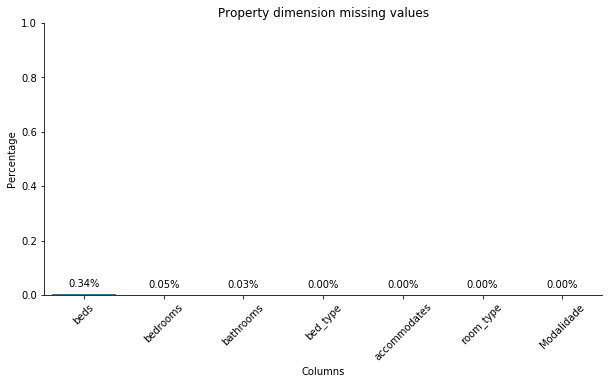

In [8]:
columns = [
'Modalidade',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'bed_type',
]

ax = missing_data(df_result,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Property dimension missing values')

## Property dimension

**Property_type**

{'Apartment', 'GuestHouse', 'House', 'Hotel/Hostel'}

NOTA: Antes tínhamos {'Apartment', 'GuestHouse', 'House', 'Hostel', 'Room'}

In [9]:
print(df_result['property_type'].value_counts())

Apartment                 13296
House                      1175
Condominium                 381
Serviced apartment          347
Villa                       295
Guesthouse                  253
Hostel                      238
Loft                        211
Boutique hotel              190
Bed and breakfast           165
Townhouse                   138
Guest suite                 120
Cottage                     115
Aparthotel                   56
Tiny house                   34
Hotel                        26
Chalet                       24
Castle                       23
Farm stay                    19
Earth house                  11
Windmill                     11
Bungalow                     11
Nature lodge                  8
Cabin                         6
Camper/RV                     4
Dome house                    3
Casa particular (Cuba)        3
Other                         2
Lighthouse                    1
Vacation home                 1
Boat                          1
Name: pr

In [10]:
df_result_processed = df_result.copy()
property_type=[]
delete=[]
index=-1

for i in df_result_processed['property_type']:
    index+=1
    if i in ["Apartment", "Serviced apartment", "Aparthotel","Loft"]:
        property_type.append("Apartment")
        continue
    if i in ["House","Townhouse","Villa","Dome house","Vacation home","Lighthouse","Casa particular (Cuba)","Tiny house","Farm stay","Cottage"]:
        property_type.append("House")
        continue
    if i in ["Guesthouse","Guest suite"]:
        property_type.append("Guesthouse")
        continue
    if i in ["Hostel","Bed and breakfast","Boutique hotel","Hotel"]:
        property_type.append("Hotel/Hostel")
        continue
    else:
        delete.append(index)

In [11]:
# Drop irrelevant instances
df_result_processed.drop(index=delete, axis=0, inplace=True)

#Reset index
df_result_processed.reset_index(inplace=True)

# Add new processed column 'property_type'
df_result_processed.insert(1,"property_type_processed", property_type)

print("Deleted rows:",len(delete))
print("Remaining instances:", df_result_processed.shape)

Deleted rows: 482
Remaining instances: (16686, 149)


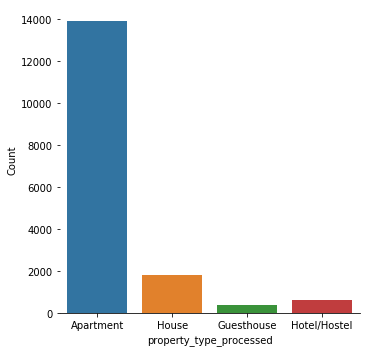

In [12]:
simple_plot(df_result_processed, "property_type_processed")

**room_type**

Room Type - {'Entire Property', 'Private Room', 'Hotel Room', 'Shared Room'}

Entire home/apt    13252
Private room        2727
Hotel room           459
Shared room          248
Name: room_type, dtype: int64


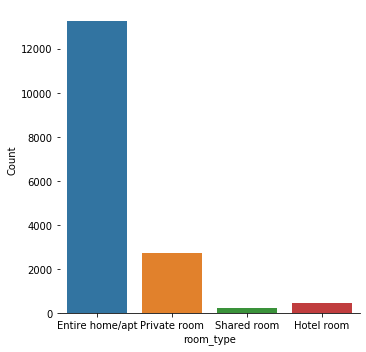

In [13]:
print(df_result_processed['room_type'].value_counts())

simple_plot(df_result_processed, "room_type")

##### **accommodates**

{'0-2','2-4','4-5','>5'}

4     5342
2     4452
6     2472
3     1575
5     1079
8      681
1      451
7      361
10     265
9      167
12     101
16      95
14      57
11      26
13      21
15      20
26       1
18       1
32       1
Name: accommodates, dtype: int64

 mu = 4.21 and sigma = 2.34



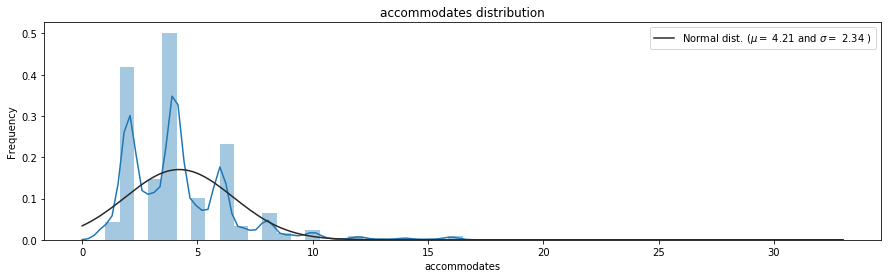

In [14]:
print(df_result['accommodates'].value_counts())
feature_dist(df_result[~df_result['accommodates'].isnull()],'accommodates')

In [15]:
df_result_processed['accommodates_processed'] = pd.qcut(df_result['accommodates'],4, duplicates='drop')
df_result_processed.accommodates_processed.value_counts()

(2.0, 4.0]      6715
(0.999, 2.0]    4792
(5.0, 32.0]     4130
(4.0, 5.0]      1049
Name: accommodates_processed, dtype: int64

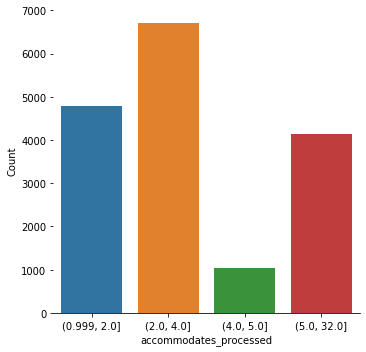

In [16]:
simple_plot(df_result_processed,'accommodates_processed')

**Bathrooms**

{'0','1','2','3','>=4'}

Bathrooms = 0 are probably shared bathrooms

1.0     11424
2.0      3138
1.5       836
3.0       706
2.5       431
4.0       138
3.5       125
0.0        75
5.0        72
4.5        48
6.0        47
5.5        34
8.0        19
0.5        16
7.0        13
9.0        13
10.0       11
6.5         4
7.5         3
12.0        2
8.5         2
24.0        1
18.0        1
9.5         1
16.5        1
13.0        1
11.5        1
Name: bathrooms, dtype: int64

 mu = 1.45 and sigma = 0.92



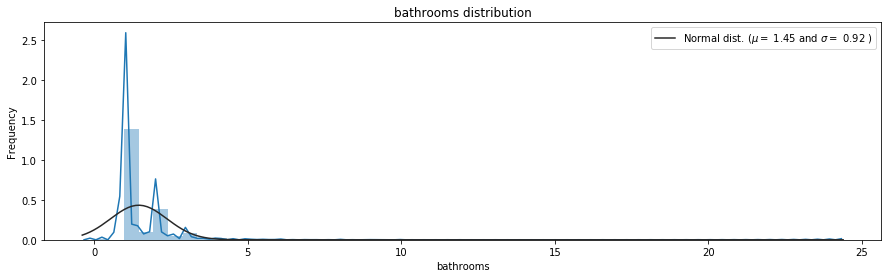

In [17]:
print(df_result['bathrooms'].value_counts())
feature_dist(df_result[~df_result['bathrooms'].isnull()],'bathrooms')

In [18]:
delete=[]
bathrooms=[]
count=-1

for i in df_result_processed['bathrooms']:
    count+=1
    if i<1.0:
        bathrooms.append('0')
        continue
    if i<2.0:
        bathrooms.append('1')
        continue
    if i<3.0:
        bathrooms.append('2')
        continue
    if i<4.0:
        bathrooms.append('3')
        continue
    if i>=4.0:
        bathrooms.append('>=4')
        continue
    else:
        delete.append(count)

In [19]:
# Drop irrelevant instances
df_result_processed.drop(index=delete, axis=0, inplace=True)
 
# Add new processed column 'bathrooms'
df_result_processed.insert(2,"bathrooms_processed", bathrooms)

print("Deleted rows:",len(delete))
print("Remaining instances:", df_result_processed.shape)

Deleted rows: 5
Remaining instances: (16681, 151)


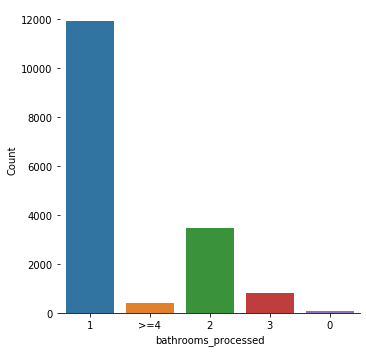

In [20]:
simple_plot(df_result_processed,'bathrooms_processed')

**Bedrooms**

{'T0','T1','T2','T3','T>=4'}

1.0      8654
2.0      4668
3.0      1910
0.0       876
4.0       585
5.0       261
6.0       104
7.0        39
8.0        25
9.0        22
10.0        6
12.0        3
15.0        1
24.0        1
100.0       1
25.0        1
11.0        1
18.0        1
16.0        1
Name: bedrooms, dtype: int64

 mu = 1.69 and sigma = 1.40



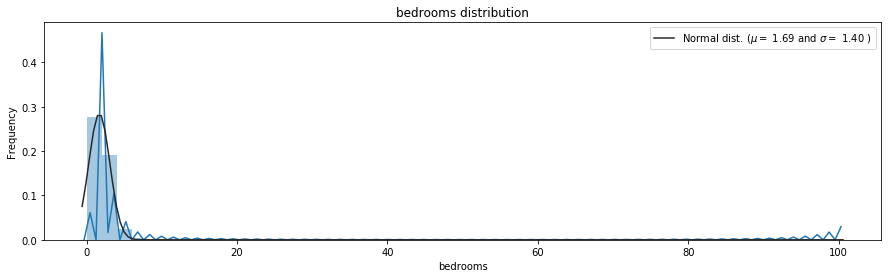

In [21]:
print(df_result['bedrooms'].value_counts())
feature_dist(df_result[~df_result['bedrooms'].isnull()],'bedrooms')

In [22]:
delete=[]
bedrooms=[]
count=-1

for i in df_result_processed['bedrooms']:
    count+=1
    if i==0.0:
        bedrooms.append('T0')
        continue
    if i==1.0:
        bedrooms.append('T1')
        continue
    if i==2.0:
        bedrooms.append('T2')
        continue
    if i==3.0:
        bedrooms.append('T3')
        continue
    if i>3.0:
        bedrooms.append('T>=4')
        continue
    else:
        delete.append(count)

In [23]:
# Drop irrelevant instances
df_result_processed.drop(index=delete, axis=0, inplace=True)
 
# Add new processed column 'bedrooms'
df_result_processed.insert(3,"bedrooms_processed", bedrooms)

print("Deleted rows:",len(delete))
print("Remaining instances:", df_result_processed.shape)

Deleted rows: 7
Remaining instances: (16674, 152)


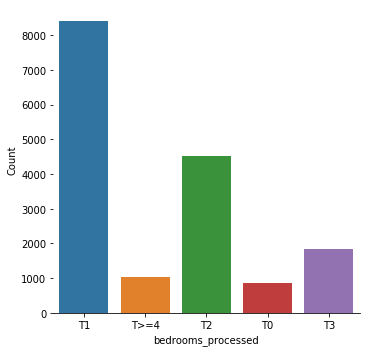

In [24]:
simple_plot(df_result_processed,'bedrooms_processed')

**beds**

{'0','1','2','3','>=4'}

1.0      5327
2.0      4652
3.0      3156
4.0      1806
5.0       795
6.0       502
7.0       208
0.0       192
8.0       181
9.0        78
10.0       71
12.0       33
11.0       28
16.0       18
14.0       16
13.0       12
15.0        8
18.0        5
17.0        3
22.0        2
26.0        2
25.0        2
30.0        2
27.0        2
23.0        2
19.0        1
50.0        1
20.0        1
38.0        1
100.0       1
28.0        1
21.0        1
Name: beds, dtype: int64

 mu = 2.62 and sigma = 2.20



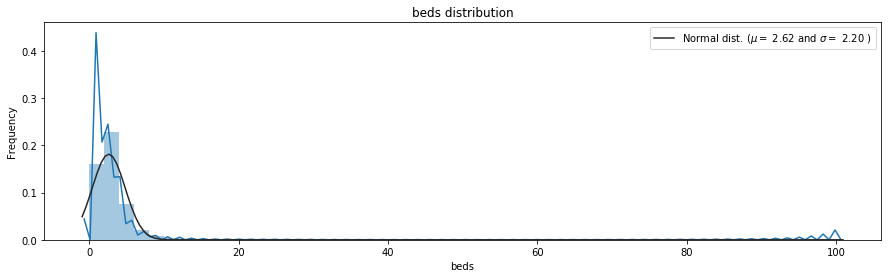

In [25]:
print(df_result['beds'].value_counts())
feature_dist(df_result[~df_result['beds'].isnull()],'beds')

In [26]:
delete=[]
beds=[]
count=-1

for i in df_result_processed['beds']:
    count+=1
    if i==0.0:
        beds.append('0')
        continue
    if i==1.0:
        beds.append('1')
        continue
    if i==2.0:
        beds.append('2')
        continue
    if i==3.0:
        beds.append('3')
        continue
    if i>3.0:
        beds.append('>=4')
        continue
    else:
        delete.append(count)

In [27]:
# Drop irrelevant instances
df_result_processed.drop(index=delete, axis=0, inplace=True)
 
# Add new processed column 'beds'
df_result_processed.insert(4,"beds_processed", beds)

print("Deleted rows:",len(delete))
print("Remaining instances:", df_result_processed.shape)

Deleted rows: 47
Remaining instances: (16627, 153)


**bed type**

{'Real Bed', 'Pull-out Sofa', 'Futon', 'Couch', 'Airbed'}

In [28]:
print(df_result['bed_type'].value_counts())

Real Bed         17092
Pull-out Sofa       62
Futon                6
Couch                5
Airbed               3
Name: bed_type, dtype: int64


**price/square feet**

!!! We still don't have this data